<a href="https://colab.research.google.com/github/034adarsh/Stock-Price-Prediction-Using-LSTM/blob/main/LSTM_Improved_model(diff_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all the required libraries

---



In [ ]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Define start day to fetch the dataset from the yahoo finance library

---



In [2]:
# Step 1: Fetch USD/CAD Data from yfinance
START = "2010-01-01"
TODAY = date.today().strftime("%Y-%m-%d")
def get_usdcad_data():
    ticker = "GC=F"  # USD/CAD exchange rate
    data = yf.download(ticker, start=START, end=TODAY)
    data.to_csv('xau_usd.csv')
    data = data[['Close']]  # Use the 'Close' price for prediction
    return data


In [3]:
data = get_usdcad_data()
df = data
df.tail()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,GC=F
Date,
2025-02-13,2925.899902
2025-02-14,2883.600098
2025-02-17,2894.699951
2025-02-18,2931.600098
2025-02-19,2919.399902


Visualizing Closing Price

In [8]:
df = df.iloc[2:].reset_index(drop=True)

# Rename the Date column correctly
df.rename(columns={'Price': 'Date'}, inplace=True)

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Convert Close column to numeric type
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Drop any remaining NaN values in Close column
df = df.dropna(subset=['Close'])

# Sort by Date
df = df.sort_values(by='Date')

# Check cleaned data
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3804 entries, 0 to 3803
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3804 non-null   datetime64[ns]
 1   Close   3804 non-null   float64       
 2   High    3804 non-null   object        
 3   Low     3804 non-null   object        
 4   Open    3804 non-null   object        
 5   Volume  3804 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 178.4+ KB


(None,
         Date        Close                High                Low  \
 0 2010-01-05  1118.099976              1126.5             1115.0   
 1 2010-01-06  1135.900024   1139.199951171875  1120.699951171875   
 2 2010-01-07  1133.099976  1133.0999755859375  1129.199951171875   
 3 2010-01-08  1138.199951   1138.199951171875  1122.699951171875   
 4 2010-01-11  1150.699951   1161.199951171875             1143.0   
 
                  Open Volume  
 0  1118.0999755859375     53  
 1  1135.9000244140625    363  
 2  1133.0999755859375     56  
 3   1138.199951171875     54  
 4   1150.699951171875    177  )

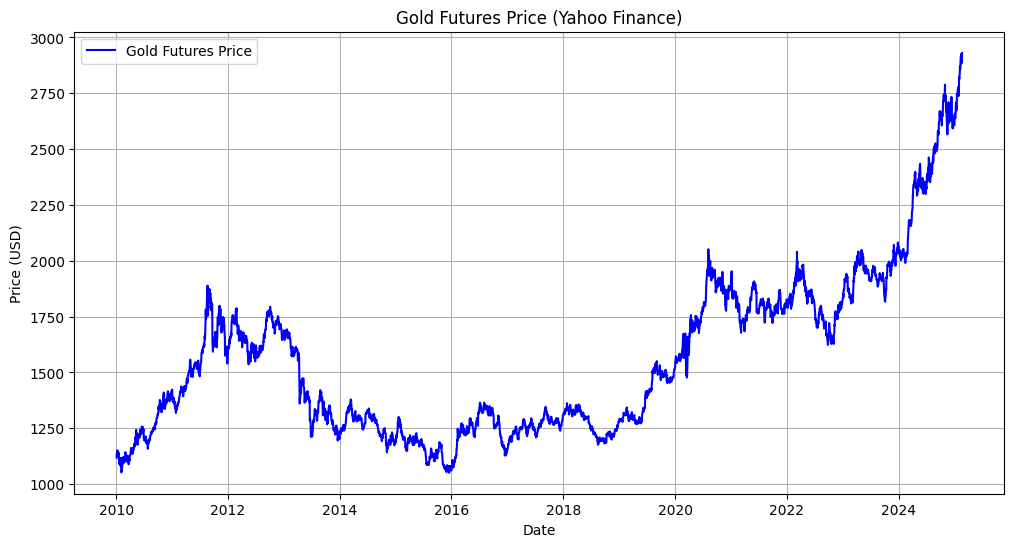

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label="Gold Futures Price", color='blue')

# Formatting the plot
plt.title("Gold Futures Price (Yahoo Finance)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

In [10]:
df

,Date,Close,High,Low,Open,Volume
0,2010-01-05,1118.099976,1126.5,1115.0,1118.0999755859375,53
1,2010-01-06,1135.900024,1139.199951171875,1120.699951171875,1135.9000244140625,363
2,2010-01-07,1133.099976,1133.0999755859375,1129.199951171875,1133.0999755859375,56
3,2010-01-08,1138.199951,1138.199951171875,1122.699951171875,1138.199951171875,54
4,2010-01-11,1150.699951,1161.199951171875,1143.0,1150.699951171875,177
...,...,...,...,...,...,...
3799,2025-02-13,2925.899902,2937.699951171875,2910.60009765625,2911.300048828125,4670
3800,2025-02-14,2883.600098,2944.39990234375,2874.800048828125,2937.300048828125,1992
3801,2025-02-17,2894.699951,2898.699951171875,2873.800048828125,2879.199951171875,1992
3802,2025-02-18,2931.600098,2936.39990234375,2873.800048828125,2879.199951171875,4010


# Spliting the dataset into training (70%) and testing (30%) set

In [11]:
# Splitting data into training and testing

train = pd.DataFrame(df[0:int(len(df)*0.70)])
test = pd.DataFrame(df[int(len(df)*0.70): int(len(df))])

print(train.shape)
print(test.shape)

(2662, 6)
(1142, 6)


In [12]:
train.head()

,Date,Close,High,Low,Open,Volume
0,2010-01-05,1118.099976,1126.5,1115.0,1118.0999755859375,53
1,2010-01-06,1135.900024,1139.199951171875,1120.699951171875,1135.9000244140625,363
2,2010-01-07,1133.099976,1133.0999755859375,1129.199951171875,1133.0999755859375,56
3,2010-01-08,1138.199951,1138.199951171875,1122.699951171875,1138.199951171875,54
4,2010-01-11,1150.699951,1161.199951171875,1143.0,1150.699951171875,177


In [13]:
test.head()

,Date,Close,High,Low,Open,Volume
2662,2020-08-06,2051.500000,2063.0,2040.0,2045.5,294
2663,2020-08-07,2010.099976,2055.0,2009.5999755859375,2040.0999755859375,808
2664,2020-08-10,2024.400024,2043.800048828125,2017.5,2026.4000244140625,233
2665,2020-08-11,1932.599976,2016.0,1904.0,2012.4000244140625,971
2666,2020-08-12,1934.900024,1946.5999755859375,1871.5999755859375,1923.0,404


# Using MinMaxScaler on the dataset

---



In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
train_close = train.iloc[:, 4:5].values # 70% close prices for training 
test_close = test.iloc[:, 4:5].values # 30% close prices for testing
print(train_close[0])
print(test_close[0]) #these really show that we are selecting the correct column

['1118.0999755859375']
['2045.5']


In [16]:
minmax_scaler = MinMaxScaler(feature_range=(0,1))
data_training_array = minmax_scaler.fit_transform(train_close)

In [17]:
#Creating a Sliding Window for non-stationary data
x_train = []
y_train = [] 

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train) 

In [18]:
x_train.shape

(2562, 100, 1)

# ML Model (LSTM)

---



In [48]:
from tensorflow.keras.layers import Dense, Dropout, LSTM,GRU
from tensorflow.keras.models import Sequential

In [49]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences=True
              ,input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))


model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))


model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))


model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

c:\Users\lostinhaze\anaconda3\envs\eda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [50]:
gru_model = Sequential()

gru_model.add(GRU(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
gru_model.add(Dropout(0.2))

gru_model.add(GRU(60, return_sequences=True))
gru_model.add(Dropout(0.3))

gru_model.add(GRU(80, return_sequences=True))
gru_model.add(Dropout(0.4))

gru_model.add(GRU(120))
gru_model.add(Dropout(0.5))

gru_model.add(Dense(units=1))

gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])



In [51]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 50)        │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100, 60)        │        20,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 100, 80)        │        34,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 120)            │        72,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,031 (527.46 KB)

 Trainable params: 135,031 (527.46 KB)

 Non-trainable params: 0 (0.00 B)

# Training the model

---



In [72]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train,epochs = 100)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 36s 301ms/step - loss: 0.0604 - mean_absolute_error: 0.1763
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - loss: 0.0091 - mean_absolute_error: 0.0690
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - loss: 0.0062 - mean_absolute_error: 0.0582
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - loss: 0.0120 - mean_absolute_error: 0.0799
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - loss: 0.0063 - mean_absolute_error: 0.0582
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step - loss: 0.0062 - mean_absolute_error: 0.0587
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 275ms/step - loss: 0.0049 - mean_absolute_error: 0.0511
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 307ms/step - loss: 0.0051 - mean_absolute_error: 0.0515
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 309ms/step - loss: 0.0043 - mean_absolute_error: 0.0481
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 270ms/step - loss: 0.0042 - mean_absolute_error: 0.0476
Epoch 11/

In [73]:
gru_model.fit(x_train, y_train,epochs = 100)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 252ms/step - loss: 0.0260 - mean_absolute_error: 0.1082
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - loss: 0.0069 - mean_absolute_error: 0.0611
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 243ms/step - loss: 0.0036 - mean_absolute_error: 0.0419
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - loss: 0.0038 - mean_absolute_error: 0.0432
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - loss: 0.0040 - mean_absolute_error: 0.0464
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 244ms/step - loss: 0.0027 - mean_absolute_error: 0.0375
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - loss: 0.0028 - mean_absolute_error: 0.0385
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - loss: 0.0030 - mean_absolute_error: 0.0390
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 243ms/step - loss: 0.0024 - mean_absolute_error: 0.0351
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - loss: 0.0028 - mean_absolute_error: 0.0383
Epoch 11/

In [74]:
model.save('lstm_model.keras')

In [75]:
gru_model.save('gru_model.keras')

In [19]:
from tensorflow.keras.models import load_model
lstm_model_path = "./lstm_model.keras"  # Path to your saved model
gru_model_path  = "./gru_model.keras"
lstm_model = load_model(lstm_model_path)
gru_model = load_model(gru_model_path)
print("Models Loaded Successfully!")

Models Loaded Successfully!


In [20]:
test_close.shape

(1142, 1)

In [21]:
past_100_days = pd.DataFrame(train_close[-100:])

In [22]:
test_df = pd.DataFrame(test_close)

**Defining the final dataset for testing by including last 100 coloums of the training dataset to get the prediction from the 1st column of the testing dataset.**

---


In [23]:
final_df = pd.concat([past_100_days, test_df], ignore_index=True)

In [24]:
final_df.head()
final_df.tail()

,0
1237,2911.300048828125
1238,2937.300048828125
1239,2879.199951171875
1240,2879.199951171875
1241,2938.699951171875


In [25]:
input_data = minmax_scaler.fit_transform(final_df)
input_data

array([[0.06791883],
       [0.        ],
       [0.04641347],
       ...,
       [0.95950728],
       [0.95950728],
       [1.        ]])

In [26]:
input_data.shape

(1242, 1)

# Testing the model

---



In [27]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
   x_test.append(input_data[i-100: i])
   y_test.append(input_data[i, 0])

In [28]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(1142, 100, 1)
(1142,)


# Making prediction and plotting the graph of predicted vs actual values

---



In [29]:
# Making predictions

gru_pred = gru_model.predict(x_test)
lstm_pred = lstm_model.predict(x_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


In [30]:
#standard_scaler.scale_


In [31]:
# scale_factor = 1/0.00041967
# y_pred = y_pred * scale_factor
# y_test = y_test * scale_factor
y_test = minmax_scaler.inverse_transform(y_test.reshape(-1, 1))
gru_pred = minmax_scaler.inverse_transform(gru_pred)
lstm_pred = minmax_scaler.inverse_transform(lstm_pred)

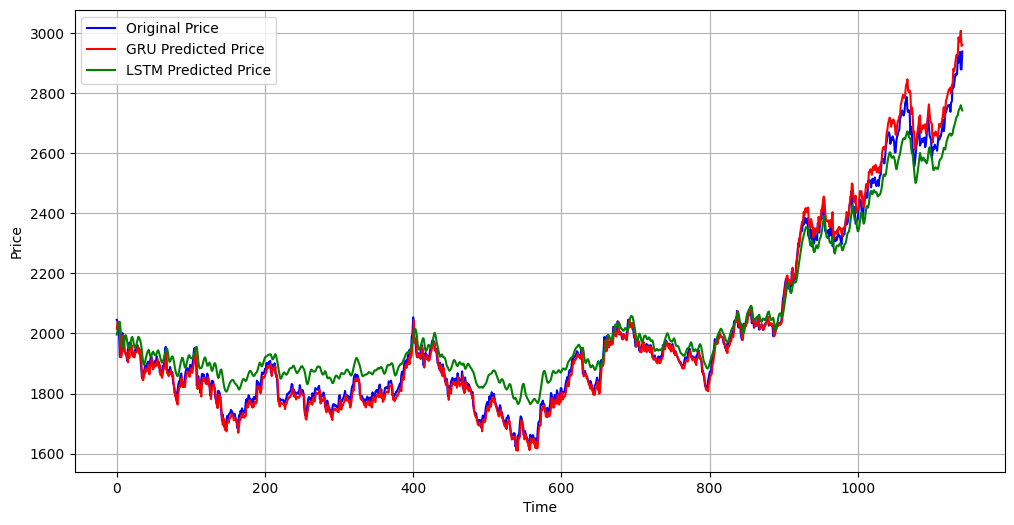

In [32]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(gru_pred, 'r', label = "GRU Predicted Price")
plt.plot(lstm_pred, 'g', label = "LSTM Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# ENSEMBLING

# XGBOOST

In [33]:
import numpy as np
from xgboost import XGBRegressor

# Train LSTM and GRU separately
lstm_preds_train = lstm_model.predict(x_train)
gru_preds_train = gru_model.predict(x_train)

# Use LSTM and GRU outputs as features
stacked_train = np.column_stack((lstm_preds_train, gru_preds_train))

# Train a Meta-Learner (XGBoost)
meta_learner = XGBRegressor(
    n_estimators=300,  # Increase number of trees
    learning_rate=0.1,  # Slightly higher learning rate
    max_depth=6,  # Increase tree depth
    gamma=0,  # Reduce regularization
    reg_lambda=1,  # Adjust L2 regularization
    subsample=0.9,  # Add randomness to training
)

meta_learner.fit(stacked_train, y_train)

# Generate test predictions
lstm_preds_test = lstm_model.predict(x_test)
gru_preds_test = gru_model.predict(x_test)

# Combine predictions
stacked_test = np.column_stack((lstm_preds_test, gru_preds_test))

# Final prediction
final_preds = meta_learner.predict(stacked_test)


81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step


In [34]:
meta_learner.save_model("final_model.json")

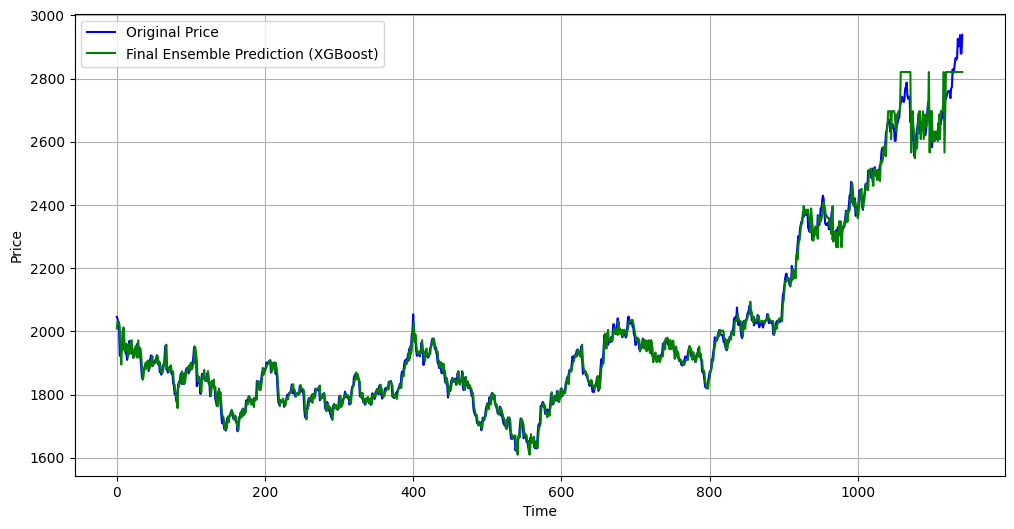

In [35]:
# Inverse transform the predictions
final_preds = final_preds.reshape(-1, 1)  # Reshape for scaler
final_preds = minmax_scaler.inverse_transform(final_preds)  # Inverse transform

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label="Original Price")
plt.plot(final_preds, 'g', label="Final Ensemble Prediction (XGBoost)")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


# ATTENTION MECHANISM

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Multiply 
from tensorflow.keras.models import Sequential


# Define attention mechanism
attention = Dense(2, activation='softmax')(stacked_train)  # Two models (LSTM, GRU)
weighted_preds = Multiply()([stacked_train, attention])

# Final meta-model
meta_model = Sequential([
    Dense(32, activation='relu', input_shape=(2,)), 
    Dense(16, activation='relu'),
    Dense(1)  # Final prediction
])
meta_model.compile(optimizer='adam', loss='mse')
meta_model.fit(weighted_preds, y_train, epochs=50, batch_size=16, verbose=1)

# Predict
attention_test = Dense(2, activation='softmax')(stacked_test)
weighted_test = Multiply()([stacked_test, attention_test])
final_preds = meta_model.predict(weighted_test)


Epoch 1/50


c:\Users\lostinhaze\anaconda3\envs\eda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0852
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.3821e-04
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1453e-04
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.9375e-04
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5820e-04
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7830e-04
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5895e-04
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3231e-04
Epoch 9/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6041e-04
Epoch 10/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6219e-04
Epoch 11/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8219e-04
Epoch 12/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4972e-04
Epoch 13/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6448e-04
Epoch 14/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6034e-04
Epoch 15/50
161/

In [39]:
meta_model.save("final_attention_model.keras")

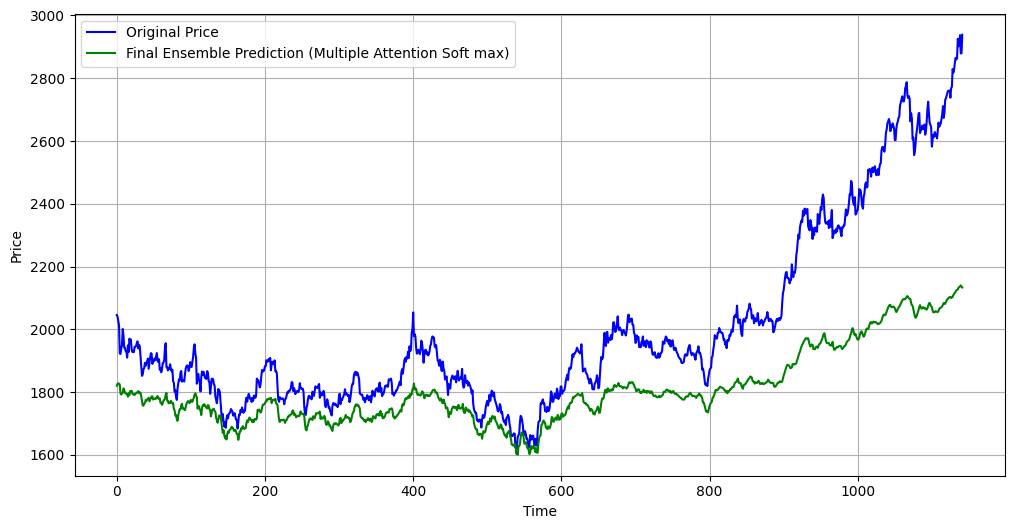

In [40]:
final_preds = final_preds.reshape(-1, 1)  # Reshape for scaler
final_preds = minmax_scaler.inverse_transform(final_preds)  # Inverse transform

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label="Original Price")
plt.plot(final_preds, 'g', label="Final Ensemble Prediction (Multiple Attention Soft max)")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# DEEP LEARNING META LEARNER

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Prepare stacked train and test datasets
stacked_train = np.column_stack((lstm_preds_train, gru_preds_train))
stacked_test = np.column_stack((lstm_preds_test, gru_preds_test))

# Define Meta-Learner (MLP)
meta_model = Sequential([
    Dense(64, activation='relu', input_shape=(2,)),  # Two input features (LSTM, GRU)
    Dense(32, activation='relu'),
    Dense(1)  # Final price prediction
])

meta_model.compile(optimizer='adam', loss='mse')
meta_model.fit(stacked_train, y_train, epochs=50, batch_size=16, verbose=1)

# Predict final ensemble output
final_preds = meta_model.predict(stacked_test)


c:\Users\lostinhaze\anaconda3\envs\eda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0447
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9377e-04
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6181e-04
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.5046e-04
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.6515e-04
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5267e-04
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.5858e-04
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.7083e-04
Epoch 9/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.7277e-04
Epoch 10/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.6245e-04
Epoch 11/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.7233e-04
Epoch 12/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5998e-04
Epoch 13/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9897e-04
Epoch 14/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.5455e-04
Epo

In [68]:
final_preds

array([[0.37060183],
       [0.3850524 ],
       [0.3842245 ],
       ...,
       [1.0013318 ],
       [0.9709932 ],
       [0.9725959 ]], dtype=float32)

In [69]:
meta_model.save("final_mlp_model.keras")

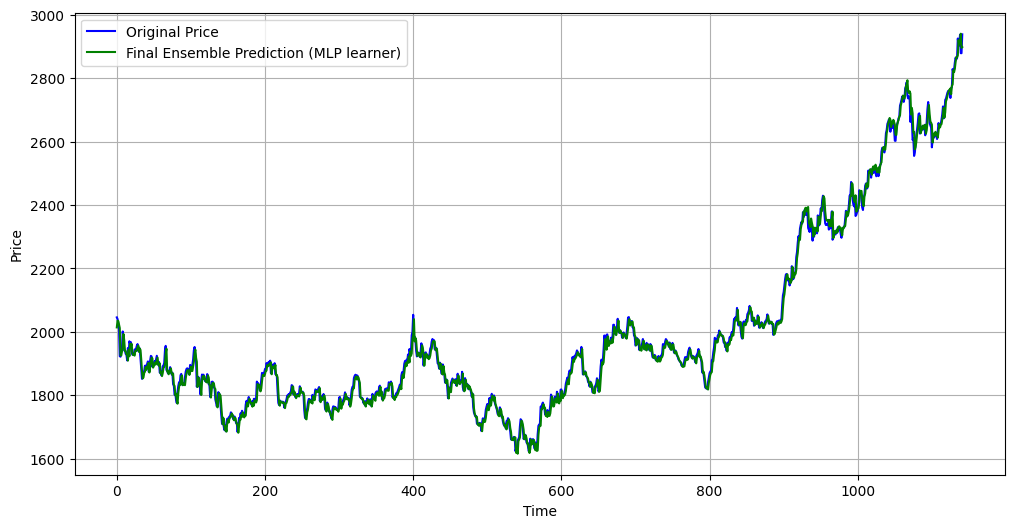

In [70]:
final_preds = final_preds.reshape(-1, 1)  # Reshape for scaler
final_preds_inversed = minmax_scaler.inverse_transform(final_preds)  # Inverse transform

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label="Original Price")
plt.plot(final_preds_inversed, 'g', label="Final Ensemble Prediction (MLP learner)")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# WEIGHTED AVERAGE DYNAMIC WEIGHTS

In [44]:
# Compute errors of LSTM and GRU
lstm_error = np.abs(y_test - lstm_preds_test)
gru_error = np.abs(y_test - gru_preds_test)

# Compute weights (lower error = higher weight)
lstm_weight = 1 / (lstm_error + 1e-8)
gru_weight = 1 / (gru_error + 1e-8)

# Normalize weights
total_weight = lstm_weight + gru_weight
lstm_weight /= total_weight
gru_weight /= total_weight

# Compute weighted predictions
final_preds = lstm_weight * lstm_preds_test + gru_weight * gru_preds_test


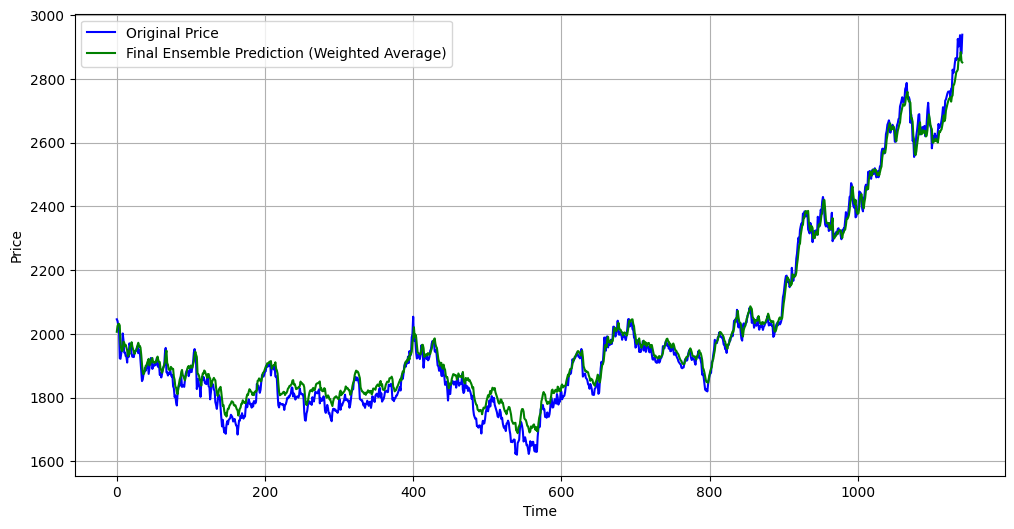

In [45]:
final_preds = final_preds.reshape(-1, 1)  # Reshape for scaler
final_preds = minmax_scaler.inverse_transform(final_preds)  # Inverse transform

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label="Original Price")
plt.plot(final_preds, 'g', label="Final Ensemble Prediction (Weighted Average)")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# BAYESIAN MODEL AVERAGING

In [46]:
from pydlm import dlm, trend, seasonality

# Define the model
model = dlm(y_train) + trend(degree=1) + seasonality(period=30)
model.fit()

# Get weights for each model dynamically
lstm_prob = model.getLatentState(filterType='forwardFilter', name='trend')[0][0]  
gru_prob = model.getLatentState(filterType='forwardFilter', name='seasonality')[0][0]  

# Normalize probabilities
total_prob = lstm_prob + gru_prob
lstm_prob /= total_prob
gru_prob /= total_prob

# Compute Bayesian weighted average
final_preds = lstm_prob * lstm_preds_test + gru_prob * gru_preds_test


INFO:pydlm:Initializing models...
INFO:pydlm:Initialization finished.
INFO:pydlm:Starting forward filtering...
INFO:pydlm:Forward filtering completed.
INFO:pydlm:Starting backward smoothing...
INFO:pydlm:Backward smoothing completed.


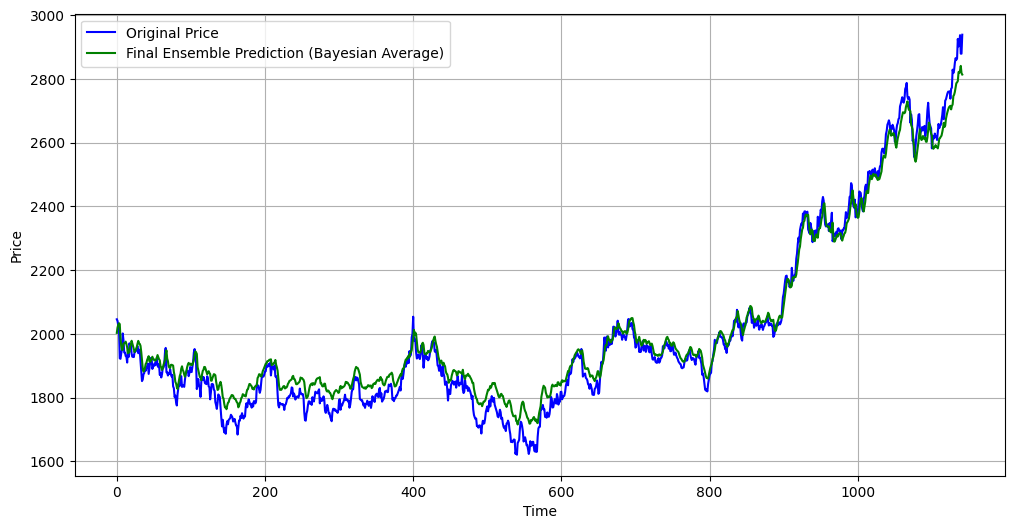

In [47]:
final_preds = final_preds.reshape(-1, 1)  # Reshape for scaler
final_preds = minmax_scaler.inverse_transform(final_preds)  # Inverse transform

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label="Original Price")
plt.plot(final_preds, 'g', label="Final Ensemble Prediction (Bayesian Average)")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Model evaluation

Calculation of mean absolute error

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_pred, y_test)

print("Mean absolute error on test set: {:.2f}".format(mse))


Mean absolute error on test set: 4114763.88


Calculation of R2 score

In [117]:
from sklearn.metrics import r2_score 

# Actual values
actual = y_test

# Predicted values
predicted = y_pred

# Calculate the R2 score
r2 = r2_score(predicted, actual)
print("R2 score:", r2)

R2 score: -73.29885279091395


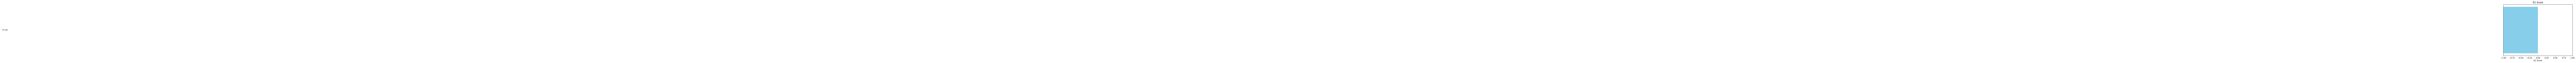

In [119]:
# Plotting the R2 score
fig, ax = plt.subplots()
ax.barh(0, r2, color='skyblue')
ax.set_xlim([-1, 1])
ax.set_yticks([])
ax.set_xlabel('R2 Score')
ax.set_title('R2 Score')

# Adding the R2 score value on the bar
ax.text(r2, 0, f'{r2:.2f}', va='center', color='black')

plt.show()

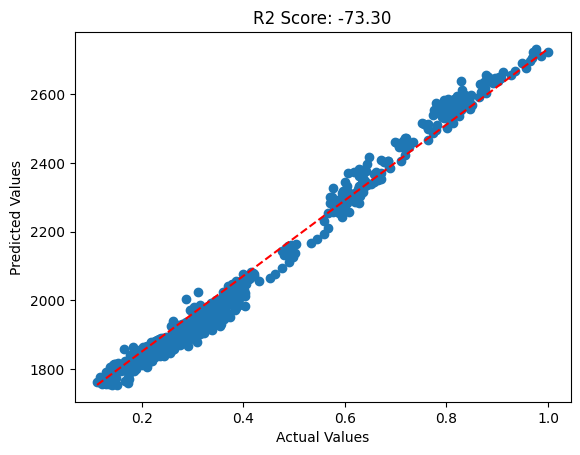

In [120]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()